Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Отлично, что стоп-слова были исключены при векторизации!
* Работа получилась отличной, тебе удалось добиться достаточно хорошего качества. Поздравляю!
* Проект зачтен, удачи в дальнейшем обучении!

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
import lightgbm as lgb
from sklearn.metrics import f1_score
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
import numpy as np
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно чтобы все импорты были собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
df=pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head(20)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно. Радует, что ты заметил дисбаланс классов.
</div>

In [6]:
def clean_re(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [7]:
df['text'] = df['text'].map(lambda x : clean_re(x))

<div class="alert alert-block alert-info">
<b>Совет: </b> Можно было еще провести лемматизацию/стемминг.
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Обработка и очистка текста проведены отлично!
</div>

In [8]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
X = df.drop('toxic', axis=1)
y = df['toxic']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Данные загружены и изучены, пропусков не обнаружено.
- Есть дисбаланс классов.
- Добавлена функция для очистки и токенизации текста с помощью регулярных выражений.
- Загружен список стоп слов.
- Добавлены переменные для признаков .

# 2. Обучение.

Для поиска оптимального значения гиперпараметров используем GridSearchCV с кросс-валидацией и расчетом TF-IDF.

**Логистическая регрессия**

In [11]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=42))])

params = {'clf__C': [0.1, 1, 10, 100],
          'clf__class_weight': ['balanced', None]}

grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid.fit(X_train['text'], y_train)
grid.best_params_

{'clf__C': 10, 'clf__class_weight': 'balanced'}

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что освоил Pipeline и для подбора параметров применил метод основанный на кросс-валидации с правильной метрикой.
</div>

**Наивный байесовский классификатор (Бернулли)**

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', BernoulliNB())])

params = {
  'clf__alpha': [0.5, 0.8, 1],
  'clf__binarize': [0.0, 0.02, 0.05],
  'clf__fit_prior': [True]}

grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid.fit(X_train['text'], y_train)
grid.best_params_

{'clf__alpha': 1, 'clf__binarize': 0.0, 'clf__fit_prior': True}

**Обучение моделей**

Создание счетчика TF-IDF

In [13]:
vect_word = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

Расчет TF-IDF

In [14]:
X_train = vect_word.fit_transform(X_train['text'])
X_test = vect_word.transform(X_test['text'])

Обучение моделей с оптимальными гиперпараметрами

In [15]:
lr_balanced = LogisticRegression(C=10, class_weight='balanced', random_state=42)
lr_balanced.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
ber = BernoulliNB(alpha=1, binarize=0.0, fit_prior=True)
ber.fit(X_train, y_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [17]:
models = [lr_balanced, ber]

Функция для расчета F1-меры. Предсказания на тестовой выборке для обученных моделей.

In [18]:
models_list = []
f1 = []
for model in models:
    test_predictions = model.predict(X_test)
    f1_valid_score = f1_score(y_test, test_predictions)
    models_list.append(type(model).__name__)
    f1.append(f1_valid_score)
    

In [19]:
print(f1)

[0.7854530678585941, 0.698546042003231]


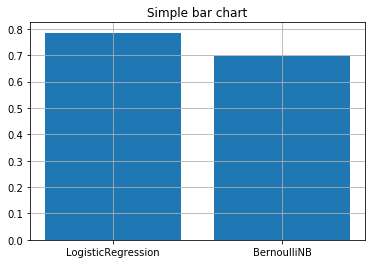

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(models_list, f1)
plt.title('Simple bar chart')
plt.grid(True) 

<div class="alert alert-block alert-success">
<b>Успех:</b> Все сделано просто идеально, так держать!
</div>

# 3. Выводы.

Лучший результат в итоге F1-меры 0.7854 у LogisticRegression. Значение  BernoulliNB вышло хуже - 0.6985.

<div class="alert alert-block alert-info">
<b>Совет: </b> Вывод можно было сделать подробнее. Например, описать обработку текста.
</div>

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны